# Cassava Leaf Disease Classification

Instantiates the Xception architecture.

In [1]:
from google.colab import drive
drive.mount('/content/drive') # Mount Google Drive to store weight

Mounted at /content/drive


In [10]:
initSystem = True
if initSystem:
  from google.colab import files

  files.upload()

  ! pip uninstall kaggle

  ! pip install -U kaggle

  !mkdir ~/.kaggle

  !cp kaggle.json ~/.kaggle/

  !chmod 600 ~/.kaggle/kaggle.json

  !kaggle competitions download -c cassava-leaf-disease-classification

  !mkdir cassava-leaf-disease-classification

  !unzip cassava-leaf-disease-classification.zip -d  cassava-leaf-disease-classification

  print("\nGet Dataset of Keras/Xception:\n")

  #!kaggle datasets download -d keras/xception
  #!unzip xception.zip -d "/content/xception" 
  #print("Xception zip file converted ! ")

  print("\nRemove the zip files:")
  
  !rm *.zip

  print("\nConverting Completed..\n")
    
  !kaggle competitions list
  print("\n Downloading trained best model")
  !wget https://github.com/AI-Learning-Platform/Cassava-Leaf-Disease-PreTrained/blob/main/GPU%20Learning/Cassava%20Leaf%20Disease-%20Transfer%20learning/v2_CLD_TransfeLearning_EfficientNet_FineTuning_BEST/best_weights.h5

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: cassava-leaf-disease-classification/train_images/3962294427.jpg  
  inflating: cassava-leaf-disease-classification/train_images/3962424026.jpg  
  inflating: cassava-leaf-disease-classification/train_images/3962684748.jpg  
  inflating: cassava-leaf-disease-classification/train_images/3962830486.jpg  
  inflating: cassava-leaf-disease-classification/train_images/3962941156.jpg  
  inflating: cassava-leaf-disease-classification/train_images/3962965208.jpg  
  inflating: cassava-leaf-disease-classification/train_images/3963041758.jpg  
  inflating: cassava-leaf-disease-classification/train_images/3963163426.jpg  
  inflating: cassava-leaf-disease-classification/train_images/3963194620.jpg  
  inflating: cassava-leaf-disease-classification/train_images/3963293417.jpg  
  inflating: cassava-leaf-disease-classification/train_images/3963421928.jpg  
  inflating: cassava-leaf-disease-classification/train_images/396350327.jpg  
  infl

**Listing competitions**

In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import warnings
import re

import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adamax
from keras.models import Sequential

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image


print('Tensorflor:', tf.__version__)

Tensorflor: 2.4.0


#Check GPU state

In [12]:
from tensorflow.python.framework.config import set_memory_growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:

from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale
Compute dtype: float16
Variable dtype: float32


**Downloading a dataset**

In [13]:
img_width = 300
img_height = 300
BATCH_SIZE = 32

#seed=64

DROPOUT_RATE = 0.2
validation_split = 0.2

epochs =40;
EPOCHS =40;
last_epoch=0;


colab = True;
if colab:
  Xception_NOTOP = 'imagenet'

  general_path = '/content/cassava-leaf-disease-classification/'
    
  json_path = general_path+'/loss_log.json'

  submission_path = '/content/submission.csv'
    
  model_saved_path = '/content/TrainedModel/ModelSaved'

else:
  Xception_NOTOP = '../input/keras-efficientnetb3-no-top-weights/efficientnetb3_notop.h5'

  general_path = '../input/cassava-leaf-disease-classification/'
    
  json_path = '/kaggle/working/loss_log.json'

  submission_path ='/kaggle/working/submission.csv'
    
  model_saved_path = '/kaggle/working/TrainedModel/ModelSaved'

In [14]:

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')


# Read train data

In [15]:
train = pd.read_csv(general_path + 'train.csv')
train['label'] = train['label'].astype('string')
display(train.head())

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


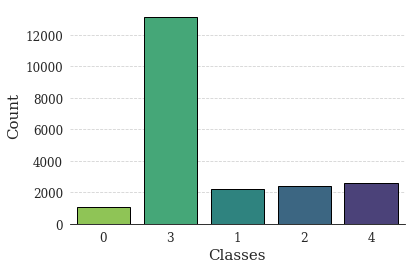

In [16]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize = (6, 4))

for i in ['top', 'right', 'left']:
    ax.spines[i].set_visible(False)
ax.spines['bottom'].set_color('black')

sns.countplot(train.label, edgecolor = 'black',
              palette = reversed(sns.color_palette("viridis", 5)))
plt.xlabel('Classes', fontfamily = 'serif', size = 15)
plt.ylabel('Count', fontfamily = 'serif', size = 15)
plt.xticks(fontfamily = 'serif', size = 12)
plt.yticks(fontfamily = 'serif', size = 12)
ax.grid(axis = 'y', linestyle = '--', alpha = 0.9)
plt.show()

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [18]:
train_datagen = ImageDataGenerator(
                            horizontal_flip=True,
                            vertical_flip=True,
                            rotation_range=20,
                            shear_range=20,
                            zoom_range=0.3,  #REVIZE                            
                            #fill_mode='nearest',
                            height_shift_range=0.1,
                            width_shift_range=0.1,                            
                            validation_split=validation_split)

train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=general_path + 'train_images',
    x_col='image_id',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=BATCH_SIZE,
    seed=seed,
    shuffle=True,
    subset='training',
    class_mode='sparse',
    validate_filenames=False)

Found 17118 non-validated image filenames belonging to 5 classes.


In [19]:
valid_datagen = keras.preprocessing.image.ImageDataGenerator( validation_split=validation_split)

valid_datagen_flow = valid_datagen.flow_from_dataframe(
    dataframe=train,
    directory=general_path + 'train_images',
    x_col='image_id',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=BATCH_SIZE,
    seed=seed,
    shuffle=True,
    subset='validation',
    class_mode='sparse',
    validate_filenames=False)

Found 4279 non-validated image filenames belonging to 5 classes.


Random photo before augmentation

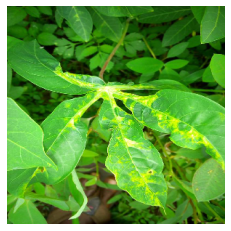

In [20]:
img_path = os.path.join(general_path, "train_images", train.image_id[20])
img = image.load_img(img_path, target_size = (img_width, img_height))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

This photo after augmentation

Found 1 validated image filenames belonging to 1 classes.


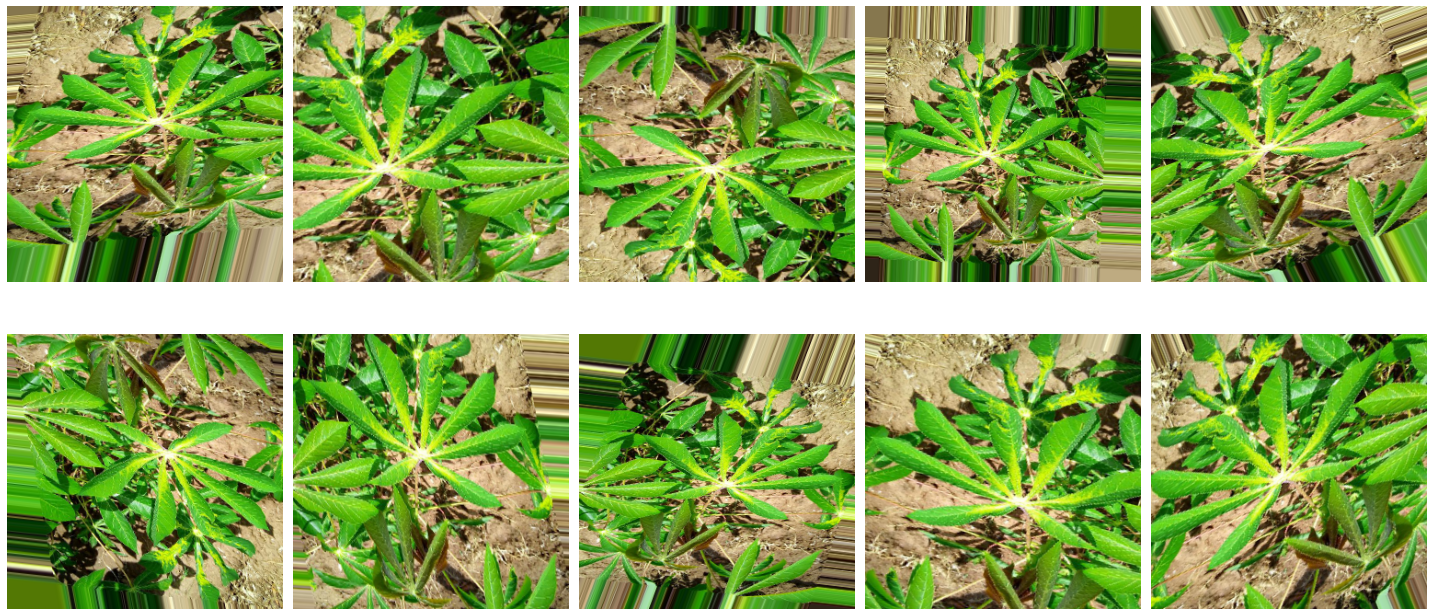

In [21]:
generator = train_datagen.flow_from_dataframe(train.iloc[20:21],
                         directory = os.path.join(general_path, "train_images"),
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (img_width, img_height),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

aug_images = [train_datagen_flow[0][0][0]/255 for i in range(10)]
fig, axes = plt.subplots(2, 5, figsize = (20, 10))
axes = axes.flatten()
for img, ax in zip(aug_images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

# Callback

1. ModelCheckpoint : Callback to save the Keras model or model weights at some frequency.

In [22]:
save_dir = '/content/drive/MyDrive/TrainedModel/EfficientNet_FineTuning_Best/'
model_checkpoint = keras.callbacks.ModelCheckpoint(
    save_dir + './best_weights.h5',
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="min"
)

2. EarlyStopping : Stop training when a monitored metric has stopped improving.

In [23]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=5,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

3. ReduceLROnPlateau : Reduce learning rate when a metric has stopped improving.

In [24]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    verbose=0,
    mode="min",
    min_delta=0.001,
)

4.Stream the epoch loss to a file in JSON format. The file content is not well-formed JSON but rather has a JSON object per line.

In [25]:
import json
json_log = open(general_path+'/loss_log.json', mode='w', buffering=1)
json_logging_callback = keras.callbacks.LambdaCallback(
    on_train_begin=lambda logs: json_log.write('{ "train": [ \n'),
    on_epoch_end=lambda epoch,logs: json_log.write(json.dumps({'epoch': epoch, 'loss': logs['loss'], 'acc':logs['accuracy']}) + ',\n'),
    on_train_end=lambda logs: json_log.write(']\n}'),
)

#Transfer learning and fine-tuning

The most common incarnation of transfer learning in the context of deep learning is the following workflow:

1.   Take layers from a previously trained model.

2.   Freeze them, so as to avoid destroying any of the information they contain 
during future training rounds.
3.   Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
4.   Train the new layers on your dataset.

####  Create base model

In [26]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomCrop(height=img_height, width=img_width),
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.25),
        layers.experimental.preprocessing.RandomZoom((0.3, 0.3)),
        layers.experimental.preprocessing.RandomContrast((0.2,0.2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(),     
        layers.Dropout(0.2),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten()
    ],
    name="img_augmentation",
)

In [27]:
# Create base model
base_model = keras.applications.EfficientNetB3( ## EfficientNetB3
    weights='imagenet', # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False) # Do not include the ImageNet classifier at the top.

# Freeze base model
base_model.trainable = False

#model.summary()

43941888/43941136 [==============================] - 1s 0us/step


####  Create new model on top.

In [28]:
# Create new model on top.
inputs = keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)  # Apply random data augmentation
x = base_model(inputs, training=False)

# The base model contains batchnorm layers. 
# We want to keep them in inference mode when we unfreeze the base model for fine-tuning, so we make sure that the base_model is running in inference mode here.
x = keras.layers.GlobalAveragePooling2D()(x)
#x = layers.BatchNormalization()(x)

# Regularize with dropout
x = keras.layers.Dropout(0.2, name="top_dropout")(x) 

outputs = keras.layers.Dense(5, activation='softmax', dtype='float32', name='predictions')(x)

model = keras.Model(inputs, outputs)

  **Print model summary**

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
top_dropout (Dropout)        (None, 1536)              0         
_________________________________________________________________
predictions (Dense)          (None, 5)                 7685      
Total params: 10,791,220
Trainable params: 7,685
Non-trainable params: 10,783,535
_________________________________________________________________


####  Compile 

In [30]:
model.compile(
    optimizer=keras.optimizers.Adamax(1e-5),  # Low learning rate -- It means 1 × 10−5. In other words, 0.00001
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.AUTO, name='sparse_categorical_crossentropy'),
    metrics=['sparse_categorical_accuracy','accuracy'],
)


  opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt)



In [31]:
# Loading trained weights epoch 64
model.load_weights('/content/drive/MyDrive/TrainedModel/best_weights.h5')

In [ ]:
print("Started Training...")

# Trains the model for a fixed number of epochs (iterations on a dataset).
history = model.fit(
    train_datagen_flow,
    epochs=80,
    steps_per_epoch=(len(train)*(1-validation_split)) // BATCH_SIZE,
    validation_data=valid_datagen_flow,
    validation_steps=(len(train)*validation_split) // BATCH_SIZE,
    callbacks = [ 
        model_checkpoint, 
        early_stopping, 
        reduce_lr,
        json_logging_callback
    ],
    use_multiprocessing=False,
    verbose=1
)
print("Training completed")

Started Training...
Epoch 1/80
213/534 [==========>...................] - ETA: 5:22 - loss: 0.8320 - sparse_categorical_accuracy: 0.6863 - accuracy: 0.6863

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.ylim(ymax = 2, ymin = 0)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Sparse Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Sparse Categorical Accuracy')
plt.legend(['Train','Test'])
plt.grid()
plt.show()

###  **Train the top layer**

#### Top Model Compile

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode since we passed `training=False` when calling it.
# This means that the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training we've done so far.

base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adamax(lr=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.AUTO, name='sparse_categorical_crossentropy'),
    metrics=['sparse_categorical_accuracy','accuracy'],
)


#### Start Training

We have defined everything we need, it's time to train the model...

In [ ]:
print("Started Training...")

# Trains the model for a fixed number of epochs (iterations on a dataset).
history = model.fit(
    train_datagen_flow,
    epochs=epochs,
    steps_per_epoch=(len(train)*(1-validation_split)) // BATCH_SIZE,
    validation_data=valid_datagen_flow,
    validation_steps=(len(train)*validation_split) // BATCH_SIZE,
    callbacks = [ 
        model_checkpoint, 
        reduce_lr,
        json_logging_callback,
        early_stopping
    ],
    use_multiprocessing=False,
    verbose=1
)
print("Training completed")

# Performance
Since the performance metric for this competition is accuracy, let us plot the train and validation accuracy to monitor our model performance.

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.ylim(ymax = 2, ymin = 0)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Sparse Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Sparse Categorical Accuracy')
plt.legend(['Train','Test'])
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.grid()
plt.show()

# Submission

In [ ]:
submission = pd.DataFrame(columns=['image_id','label'])
for image_name in os.listdir(general_path + 'test_images'):
    image_path = os.path.join(general_path + 'test_images', image_name)
    image = tf.keras.preprocessing.image.load_img(image_path)
    resized_image = image.resize((512, 512))
    numpied_image = np.expand_dims(resized_image, 0)
    tensored_image = tf.cast(numpied_image, tf.float32)
    
    predictions = model.predict(tensored_image)
    print(np.argmax(predictions[0]))
    submission = submission.append(pd.DataFrame({'image_id': image_name,
                                                 'label': [np.argmax(predictions[0])]}))
    
    submission.to_csv(submission_path, index=False)

In [ ]:
model.save('/content/TrainedModel/ModelSaved')

In [ ]:
#!kaggle competitions submit -c humpback-whale-identification -f submission.csv -m "Message"

In [ ]:
"""
model = keras.models.Sequential()
model.add(keras.applications.EfficientNetB3(
    input_shape=(img_height, img_width, 3), 
    weights='imagenet', 
    include_top=False)
)

model.add(keras.layers.GlobalAveragePooling2D())
model.add(layers.Dropout(DROPOUT_RATE))
#model.add(layers.BatchNormalization())
model.add(keras.layers.Dense(5, activation='softmax', dtype='float32', name='predictions'))
"""